## Konfiguracja środowiska do trenowania modelu BART

Ten fragment kodu przygotowuje środowisko do trenowania modelu BART, wykorzystując PyTorch oraz bibliotekę Transformers. Obejmuje konfigurację urządzenia, załadowanie plików danych oraz ustawienie parametrów globalnych.

### Szczegółowy opis:

1. **Sprawdzenie wsparcia dla Metal Performance Shaders (MPS)**:
   - Na macOS sprawdzana jest dostępność MPS, co pozwala na przyspieszenie obliczeń na procesorach Apple Silicon.
   - Jeśli MPS nie jest dostępny, kod używa CPU.

2. **Globalna konfiguracja (`CONFIG`)**:
   - Słownik `CONFIG` definiuje kluczowe parametry trenowania:
     - `train_file`, `val_file`, `test_file`: Ścieżki do plików JSON zawierających dane podzielone na zbiory treningowe, walidacyjne i testowe.
     - `batch_size`: Rozmiar partii danych w DataLoaderze (6 próbek na partię).
     - `epochs`: Liczba epok trenowania (5 iteracji przez cały zbiór treningowy).
     - `learning_rate`: Współczynnik uczenia dla optymalizatora AdamW.
     - `max_length`: Maksymalna długość tokenów po tokenizacji (512 tokenów).
     - `seed`: Ziarno losowości dla powtarzalności wyników.

3. **Ustawienie ziarna losowości**:
   - Kod ustawia ziarno losowości dla modułów `random` i `torch`, co zapewnia powtarzalność wyników podczas trenowania i generowania danych.

4. **Urządzenie obliczeniowe**:
   - Informacja o używanym urządzeniu jest drukowana w konsoli (`Using device: mps` lub `Using device: cpu`).

### Uwagi:
- Wymagana jest instalacja biblioteki Transformers (`pip install transformers`) oraz PyTorch z odpowiednim wsparciem dla MPS lub CPU.
- Globalna konfiguracja ułatwia szybkie dostosowanie parametrów trenowania bez konieczności modyfikowania kodu.
- Ziarno losowości gwarantuje, że wyniki będą takie same przy każdym uruchomieniu.

In [18]:
import os
import torch
import random
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Check for Metal Performance Shaders (MPS) support on macOS
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Global configuration dictionary
CONFIG = {
    "train_file": "./datasets/splits_filtered_with_summary/train.json",
    "val_file": "./datasets/splits_filtered_with_summary/val.json",
    "test_file": "./datasets/splits_filtered_with_summary/test.json",
    "batch_size": 6,  # Batch size for DataLoader
    "epochs": 5,  # Number of training epochs
    "learning_rate": 3e-5,  # Learning rate for the optimizer
    "max_length": 512,  # Maximum sequence length for tokenization
    "seed": 42  # Random seed for reproducibility
}

# Set the seed for reproducibility
random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

Using device: mps


## Przygotowanie i tokenizacja danych do trenowania modelu BART

Ten fragment kodu wczytuje dane z plików JSON, tokenizuje je i tworzy dedykowany zbiór danych (`Dataset`) dla modelu BART. Zbiory treningowe, walidacyjne i testowe są następnie przygotowane do użycia w procesie trenowania.

### Szczegółowy opis:

1. **Wczytanie danych z plików JSON**:
   - Funkcja `load_json_data(file_path)` wczytuje dane z podanego pliku JSON i zwraca listę słowników zawierających `id`, `text`, oraz `summary`.
   - Dane wczytywane są z plików określonych w konfiguracji `CONFIG`:
     - `CONFIG["train_file"]`: Plik ze zbiorem treningowym.
     - `CONFIG["val_file"]`: Plik ze zbiorem walidacyjnym.
     - `CONFIG["test_file"]`: Plik ze zbiorem testowym.

2. **Klasa `TextDataset`**:
   - Dedykowana klasa `Dataset` oparta na PyTorch do obsługi danych tokenizowanych.
   - Argumenty:
     - `data`: Lista danych z kluczami `text` i `summary`.
     - `tokenizer`: Tokenizer BART-a (`facebook/bart-base`).
     - `max_length`: Maksymalna długość tokenów (określona w `CONFIG`).
   - Metody:
     - `__len__`: Zwraca liczbę przykładów w zbiorze danych.
     - `__getitem__`: Tokenizuje dane wejściowe (`text`) i dane docelowe (`summary`) dla konkretnego przykładu. Zwraca:
       - `input_ids`: Tokeny wejściowe.
       - `attention_mask`: Maska uwagi dla tokenów wejściowych.
       - `labels`: Tokeny docelowe dla streszczenia.

3. **Tworzenie zbiorów danych**:
   - Zbiory treningowe, walidacyjne i testowe są tworzone przy użyciu klasy `TextDataset`.
   - Parametry tokenizera, takie jak `max_length`, są zgodne z globalną konfiguracją.

4. **Podsumowanie zbiorów danych**:
   - Drukowana jest liczba przykładów w każdym zbiorze (`train`, `val`, `test`).

### Wynik:
- Dane wejściowe i docelowe są odpowiednio tokenizowane i przygotowane w formacie kompatybilnym z PyTorch DataLoader.
- Kod umożliwia łatwe rozszerzenie na inne modele i konfiguracje, zapewniając skalowalność.

### Uwagi:
- Tokenizer BART-a musi być załadowany za pomocą biblioteki Hugging Face Transformers (`pip install transformers`).
- Zbiory danych można łatwo używać w procesie trenowania z wykorzystaniem PyTorch.
- Klasa `TextDataset` zapewnia czytelność i modularność kodu.

In [20]:
from torch.utils.data import Dataset
import json

# Load the tokenizer for BART
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Function to load JSON data from a file
def load_json_data(file_path):
    """
    Load JSON data from a file.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        list: A list of dictionaries with "id", "text", and "summary".
    """
    with open(file_path, "r") as file:
        return json.load(file)

# Load train, validation, and test data
train_data = load_json_data(CONFIG["train_file"])
val_data = load_json_data(CONFIG["val_file"])
test_data = load_json_data(CONFIG["test_file"])

class TextDataset(Dataset):
    """
    Custom PyTorch Dataset to handle tokenized input for BART fine-tuning.
    """
    def __init__(self, data, tokenizer, max_length):
        """
        Initialize the dataset with tokenized data.

        Args:
            data (list): List of dictionaries with "text" and "summary".
            tokenizer (BartTokenizer): Tokenizer for BART.
            max_length (int): Maximum sequence length for tokenization.
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Tokenize a specific example and prepare input/output tensors.

        Args:
            idx (int): Index of the example.

        Returns:
            dict: Dictionary containing input_ids, attention_mask, and labels.
        """
        entry = self.data[idx]
        input_text = entry["text"]
        target_text = entry["summary"]

        # Tokenize the input text
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Tokenize the target text
        targets = self.tokenizer(
            target_text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": targets["input_ids"].squeeze(0)
        }

# Create datasets for train, validation, and test
train_dataset = TextDataset(train_data, tokenizer, CONFIG["max_length"])
val_dataset = TextDataset(val_data, tokenizer, CONFIG["max_length"])
test_dataset = TextDataset(test_data, tokenizer, CONFIG["max_length"])

# Print a summary of the datasets
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

Training examples: 14815
Validation examples: 7407
Test examples: 2470


## Przygotowanie DataLoaderów

Ten fragment kodu tworzy DataLoadery dla zbiorów treningowego, walidacyjnego i testowego, umożliwiając efektywne przetwarzanie danych w partiach podczas trenowania i ewaluacji modelu BART.

### Szczegółowy opis:

1. **Funkcja `prepare_data_loaders`**:
   - Tworzy DataLoadery dla podanych zbiorów danych.
   - Argumenty:
     - `train_dataset`: Zbiór danych treningowych.
     - `val_dataset`: Zbiór danych walidacyjnych.
     - `test_dataset`: Zbiór danych testowych.
     - `batch_size`: Liczba przykładów w jednej partii (batch).
   - Zwraca krotkę z DataLoaderami dla zbiorów:
     - `train_loader`: DataLoader z danymi treningowymi (shuffle=True dla losowego porządku).
     - `val_loader`: DataLoader z danymi walidacyjnymi (shuffle=False, dane w określonej kolejności).
     - `test_loader`: DataLoader z danymi testowymi (shuffle=False).

2. **Przygotowanie DataLoaderów**:
   - DataLoadery są tworzone z wykorzystaniem klasy `DataLoader` z PyTorch.
   - Rozmiar partii jest definiowany w konfiguracji `CONFIG["batch_size"]`.

3. **Podsumowanie DataLoaderów**:
   - Wyświetlana jest liczba partii danych dla każdego zbioru:
     - `Train DataLoader batches`: Liczba partii w zbiorze treningowym.
     - `Validation DataLoader batches`: Liczba partii w zbiorze walidacyjnym.
     - `Test DataLoader batches`: Liczba partii w zbiorze testowym.

### Wynik:
- DataLoadery są gotowe do użycia w procesie trenowania i ewaluacji modelu.
- Liczba partii w każdym DataLoaderze zależy od liczby przykładów w zbiorze danych i rozmiaru partii (`batch_size`).

### Uwagi:
- DataLoadery automatycznie ładują dane w partiach, co poprawia wydajność trenowania.
- Ustawienie `shuffle=True` w zbiorze treningowym pozwala na losowe wybieranie danych, co zapobiega problemowi nadmiernego dopasowania (overfitting).
- Funkcja jest modularna i może być ponownie wykorzystana w innych projektach NLP.

In [3]:
from torch.utils.data import DataLoader

def prepare_data_loaders(train_dataset, val_dataset, test_dataset, batch_size):
    """
    Prepare DataLoaders for train, validation, and test datasets.

    Args:
        train_dataset (Dataset): Dataset for training.
        val_dataset (Dataset): Dataset for validation.
        test_dataset (Dataset): Dataset for testing.
        batch_size (int): Batch size for DataLoaders.

    Returns:
        tuple: DataLoaders for train, validation, and test datasets.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Prepare DataLoaders
train_loader, val_loader, test_loader = prepare_data_loaders(
    train_dataset, val_dataset, test_dataset, CONFIG["batch_size"]
)

# Print a summary of DataLoaders
print(f"Train DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")
print(f"Test DataLoader batches: {len(test_loader)}")

Train DataLoader batches: 2470
Validation DataLoader batches: 1235
Test DataLoader batches: 412


## Inicjalizacja modelu BART i optymalizatora

Ten fragment kodu ładuje wstępnie wytrenowany model BART, przenosi go na odpowiednie urządzenie obliczeniowe i definiuje optymalizator do trenowania modelu.

### Szczegółowy opis:

1. **Ładowanie modelu BART**:
   - Model `BartForConditionalGeneration` jest wczytywany z pretrenowanego modelu `facebook/bart-base` z biblioteki Hugging Face Transformers.
   - Ten model jest przeznaczony do generacji tekstu, np. streszczeń.

2. **Przenoszenie modelu na urządzenie**:
   - Model jest przenoszony na urządzenie określone w zmiennej `device`:
     - MPS (dla macOS z Apple Silicon) lub CPU, jeśli MPS nie jest dostępne.
   - To umożliwia wykorzystanie odpowiedniego sprzętu do obliczeń.

3. **Definiowanie optymalizatora**:
   - Optymalizator `AdamW` (optymalizator Adam z regularizacją wag) jest tworzony do aktualizacji wag modelu.
   - Współczynnik uczenia (`learning_rate`) jest ustawiany zgodnie z wartością z konfiguracji `CONFIG["learning_rate"]`.

4. **Podsumowanie**:
   - Wyświetlany jest komunikat potwierdzający załadowanie modelu i przeniesienie go na urządzenie.

### Wynik:
- Model BART jest gotowy do trenowania lub ewaluacji.
- Optymalizator został skonfigurowany do aktualizowania parametrów modelu podczas procesu trenowania.


In [4]:
from transformers import BartForConditionalGeneration
from torch.optim import AdamW

# Load the pre-trained BART model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

# Move the model to the appropriate device
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=CONFIG["learning_rate"])

# Print model summary
print("Model loaded and moved to device.")

Model loaded and moved to device.


## Walidacja zbiorów danych

Ten fragment kodu waliduje zbiory danych (treningowy, walidacyjny, testowy), aby upewnić się, że wszystkie wpisy zawierają wymagane klucze `"text"` i `"summary"`. 

### Szczegółowy opis:

1. **Funkcja `validate_dataset`**:
   - Przeszukuje listę słowników (`data`) i sprawdza, czy każdy wpis zawiera klucze `"text"` i `"summary"`.
   - Argumenty:
     - `data`: Lista słowników do walidacji.
   - Zwraca:
     - Listę nieprawidłowych wpisów w formacie `(index, entry)`, gdzie:
       - `index`: Indeks wpisu w liście.
       - `entry`: Treść wpisu.

2. **Walidacja zbiorów danych**:
   - Funkcja `validate_dataset` jest wywoływana dla każdego ze zbiorów:
     - `train_data` (zbiór treningowy).
     - `val_data` (zbiór walidacyjny).
     - `test_data` (zbiór testowy).
   - Wynik walidacji to liczba nieprawidłowych wpisów w każdym zbiorze, wyświetlana w konsoli.

3. **Wyjście**:
   - Liczba wpisów bez wymaganych kluczy (`"text"` i `"summary"`) jest drukowana dla każdego zbioru danych:
     - `Invalid entries in train dataset`.
     - `Invalid entries in validation dataset`.
     - `Invalid entries in test dataset`.

### Wynik:
- Jeśli wszystkie wpisy w zbiorach danych są prawidłowe, funkcja zwraca puste listy dla każdego zbioru.
- Jeśli występują nieprawidłowe wpisy, użytkownik otrzymuje ich liczbę oraz szczegóły (indeksy i zawartość).

### Uwagi:
- Walidacja jest kluczowa przed przystąpieniem do trenowania modelu, aby uniknąć błędów w procesie tokenizacji i generacji tekstu.
- Funkcja jest uniwersalna i może być używana do walidacji innych zbiorów danych w formacie listy słowników.

In [5]:
def validate_dataset(data):
    """
    Validates the dataset to ensure all entries contain "text" and "summary".

    Args:
        data (list): List of dictionaries to validate.

    Returns:
        list: A list of invalid entries with their indices.
    """
    invalid_entries = []
    for idx, entry in enumerate(data):
        if "text" not in entry or "summary" not in entry:
            invalid_entries.append((idx, entry))
    return invalid_entries

# Validate train, validation, and test datasets
print("Validating train dataset...")
invalid_train = validate_dataset(train_data)
print(f"Invalid entries in train dataset: {len(invalid_train)}")

print("Validating validation dataset...")
invalid_val = validate_dataset(val_data)
print(f"Invalid entries in validation dataset: {len(invalid_val)}")

print("Validating test dataset...")
invalid_test = validate_dataset(test_data)
print(f"Invalid entries in test dataset: {len(invalid_test)}")

Validating train dataset...
Invalid entries in train dataset: 0
Validating validation dataset...
Invalid entries in validation dataset: 0
Validating test dataset...
Invalid entries in test dataset: 0


## Inspekcja DataLoaderów

Ten fragment kodu inspektuje DataLoadery dla zbiorów treningowego, walidacyjnego i testowego, aby upewnić się, że są poprawnie skonfigurowane i zawierają dane w odpowiednim formacie.

### Szczegółowy opis:

1. **Funkcja `inspect_data_loaders`**:
   - Inspektuje podany `DataLoader`, wyświetlając szczegóły dotyczące pierwszej partii danych.
   - Argumenty:
     - `loader`: DataLoader, który ma być inspektowany.
     - `loader_name`: Nazwa DataLoadera, używana do logowania informacji.
   - Funkcja wyświetla:
     - Klucze w partii danych (`input_ids`, `attention_mask`, `labels`).
     - Kształt (`shape`) każdej składowej partii danych.
   - Obsługuje potencjalne błędy, aby zapobiec przerwaniu działania w przypadku nieprawidłowego DataLoadera.

2. **Inspekcja zbiorów danych**:
   - Inspekcja jest przeprowadzana dla trzech DataLoaderów:
     - `train_loader`: Zbiór treningowy.
     - `val_loader`: Zbiór walidacyjny.
     - `test_loader`: Zbiór testowy.
   - Dla każdego DataLoadera drukowane są szczegóły pierwszej partii.

3. **Wyjście**:
   - Wyświetlane są klucze partii danych, np.:
     - `input_ids`: Tokeny wejściowe.
     - `attention_mask`: Maska uwagi dla tokenów wejściowych.
     - `labels`: Tokeny docelowe.
   - Wyświetlany jest kształt danych dla każdego klucza, co pozwala zweryfikować, czy dane są odpowiednio przygotowane.

### Wynik:
- Jeśli DataLoadery są poprawnie skonfigurowane, użytkownik zobaczy szczegóły pierwszej partii dla każdego DataLoadera.
- Jeśli występują błędy w danych lub konfiguracji DataLoadera, zostaną wyświetlone odpowiednie komunikaty o błędach.

### Uwagi:
- Inspekcja DataLoaderów jest kluczowym krokiem w weryfikacji poprawności konfiguracji przed rozpoczęciem trenowania modelu.
- Funkcja może być rozszerzona o dodatkowe sprawdzenia, takie jak wartości danych (np. minimalne/maksymalne wartości tokenów).
- Umożliwia szybkie zidentyfikowanie problemów, takich jak brakujące klucze lub nieprawidłowe kształty tensorów.

In [6]:
# Inspect DataLoaders to ensure they are correctly set up
def inspect_data_loaders(loader, loader_name):
    """
    Inspects a DataLoader by printing a summary of the first batch.

    Args:
        loader (DataLoader): DataLoader to inspect.
        loader_name (str): Name of the DataLoader for logging purposes.

    Returns:
        None
    """
    print(f"\nInspecting {loader_name}...")
    try:
        # Get the first batch
        for batch in loader:
            print(f"Batch keys in {loader_name}: {list(batch.keys())}")
            print(f"Sample 'input_ids' shape: {batch['input_ids'].shape}")
            print(f"Sample 'attention_mask' shape: {batch['attention_mask'].shape}")
            print(f"Sample 'labels' shape: {batch['labels'].shape}")
            break  # Stop after the first batch
    except Exception as e:
        print(f"Error inspecting {loader_name}: {e}")

# Inspect the train, validation, and test DataLoaders
inspect_data_loaders(train_loader, "Train DataLoader")
inspect_data_loaders(val_loader, "Validation DataLoader")
inspect_data_loaders(test_loader, "Test DataLoader")


Inspecting Train DataLoader...
Batch keys in Train DataLoader: ['input_ids', 'attention_mask', 'labels']
Sample 'input_ids' shape: torch.Size([6, 512])
Sample 'attention_mask' shape: torch.Size([6, 512])
Sample 'labels' shape: torch.Size([6, 512])

Inspecting Validation DataLoader...
Batch keys in Validation DataLoader: ['input_ids', 'attention_mask', 'labels']
Sample 'input_ids' shape: torch.Size([6, 512])
Sample 'attention_mask' shape: torch.Size([6, 512])
Sample 'labels' shape: torch.Size([6, 512])

Inspecting Test DataLoader...
Batch keys in Test DataLoader: ['input_ids', 'attention_mask', 'labels']
Sample 'input_ids' shape: torch.Size([6, 512])
Sample 'attention_mask' shape: torch.Size([6, 512])
Sample 'labels' shape: torch.Size([6, 512])


## Wyświetlanie losowych przykładów ze zbiorów danych

Ten fragment kodu wczytuje dane z plików JSON i wyświetla losowy przykład z każdego zbioru danych (treningowego, walidacyjnego i testowego). Pomaga to szybko zweryfikować zawartość danych w każdym zbiorze.

### Szczegółowy opis:

1. **Funkcja `display_random_sample`**:
   - Wyświetla losowy przykład ze zbioru danych.
   - Argumenty:
     - `file_path`: Ścieżka do pliku JSON zawierającego zbiór danych.
     - `dataset_name`: Nazwa zbioru danych, używana w komunikatach (np. "Train", "Validation", "Test").
   - Kroki:
     - Wczytuje dane z pliku JSON.
     - Sprawdza, czy zbiór danych nie jest pusty.
     - Wybiera losowy przykład i wyświetla:
       - `ID`: Unikalny identyfikator przykładu.
       - `Text`: Treść artykułu.
       - `Summary`: Streszczenie artykułu.

2. **Obsługa błędów**:
   - Sprawdza, czy plik istnieje. Jeśli plik nie zostanie znaleziony, wyświetla odpowiedni komunikat.
   - Obsługuje inne potencjalne błędy (np. problemy z odczytem pliku) i wyświetla informacje o błędzie.

3. **Wyświetlanie przykładów**:
   - Funkcja jest wywoływana dla trzech zbiorów danych:
     - `train.json` (zbiór treningowy).
     - `val.json` (zbiór walidacyjny).
     - `test.json` (zbiór testowy).
   - Wyświetlane są szczegóły losowo wybranego przykładu z każdego zbioru.

### Wynik:
- Dla każdego zbioru danych wyświetlany jest losowy przykład, który zawiera:
  - `ID`: Unikalny identyfikator przykładu.
  - `Text`: Treść artykułu (przykładowy tekst).
  - `Summary`: Streszczenie artykułu.
- Przykłady są oddzielone poziomą linią (`-`).

### Uwagi:
- Funkcja pozwala szybko zweryfikować poprawność i zawartość danych w każdym zbiorze.
- Jeśli zbiór danych jest pusty, wyświetlany jest komunikat informujący o braku danych.
- Kod jest elastyczny i może być używany do przeglądania dowolnych zbiorów danych w formacie JSON z kluczami `id`, `text` i `summary`.

In [7]:
import json
import random

def display_random_sample(file_path, dataset_name):
    """
    Displays a random sample from the given dataset file.

    Args:
        file_path (str): Path to the JSON file.
        dataset_name (str): Name of the dataset (e.g., "Train", "Validation", "Test").
    """
    try:
        with open(file_path, "r") as file:
            data = json.load(file)  # Load JSON data
            if not data:
                print(f"The {dataset_name} dataset is empty!")
                return
            
            sample = random.choice(data)  # Select a random sample
            print(f"\nRandom Sample from {dataset_name} Dataset:")
            print(f"ID: {sample['id']}")
            print(f"Text:\n{sample['text']}\n")
            print(f"Summary:\n{sample['summary']}\n")
            print("-" * 80)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error reading {dataset_name} dataset: {e}")

# Display random samples from train, validation, and test datasets
display_random_sample("./datasets/splits_filtered_with_summary/train.json", "Train")
display_random_sample("./datasets/splits_filtered_with_summary/val.json", "Validation")
display_random_sample("./datasets/splits_filtered_with_summary/test.json", "Test")


Random Sample from Train Dataset:
ID: NPR-39426
Text:
Time now for business news. Thanks to a successful bid, the leading port operator in the Middle East will now control six terminals at U.S. ports. Dubai Ports World won a bidding contest for the United Kingdom's P&O ports. Some in the United States are expressing security concerns about the United Arab Emerits controlling American ports. NPR's Adam Davidson has the story. New York Senator Charles Schumer is taking the lead on attacking the deal by using language sure to get any New Yorker's attention. In our post-911 world, you can't be too careful. And the fact that the United Arab Emerits, even though it is now an ally of the United States, was the place where many of the hijackers came, should ring alarm bells when we hear that a company controlled by the United Arab Emerits is in charge of security now at our ports. Schumer painted a grim picture of potential terrorists taking over our nations entryways. This deal would give th

## Inicjalizacja modelu BART, optymalizatora i gradient scaler

Ten fragment kodu przygotowuje model BART do trenowania, definiuje optymalizator oraz wprowadza mechanizm mieszanej precyzji, co przyspiesza trening i redukuje użycie pamięci.

### Szczegółowy opis:

1. **Ładowanie modelu BART**:
   - Model `BartForConditionalGeneration` wczytywany jest z pretrenowanego modelu `facebook/bart-base` za pomocą biblioteki Transformers.
   - Model jest przenoszony na urządzenie określone w zmiennej `device` (MPS lub CPU).

2. **Definiowanie optymalizatora**:
   - Optymalizator `AdamW` jest inicjalizowany do aktualizacji wag modelu podczas procesu trenowania.
   - Współczynnik uczenia (`lr`) jest ustawiany na wartość określoną w konfiguracji `CONFIG["learning_rate"]`.

3. **DataLoadery**:
   - Funkcja `prepare_data_loaders` (zdefiniowana wcześniej) jest używana do stworzenia DataLoaderów dla zbiorów:
     - Treningowego (`train_loader`).
     - Walidacyjnego (`val_loader`).
     - Testowego (`test_loader`).
   - Rozmiar partii danych jest określony w konfiguracji `CONFIG["batch_size"]`.

4. **Inicjalizacja gradient scaler**:
   - Mechanizm `GradScaler` z biblioteki PyTorch jest używany do trenowania w mieszanej precyzji.
   - Pozwala to na wykonywanie obliczeń w precyzji FP16 tam, gdzie to możliwe, co przyspiesza trening i redukuje obciążenie pamięci.

5. **Potwierdzenie inicjalizacji**:
   - Po wczytaniu modelu, zdefiniowaniu optymalizatora i inicjalizacji gradient scaler, wyświetlany jest komunikat potwierdzający gotowość do treningu.

### Wynik:
- Model, optymalizator i gradient scaler są w pełni zainicjalizowane i gotowe do trenowania.
- DataLoadery zapewniają efektywne ładowanie danych w partiach.


In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
from torch.cuda.amp import GradScaler, autocast

# Load the pre-trained BART model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=CONFIG["learning_rate"])

# Define the DataLoaders (reuse from earlier)
train_loader, val_loader, test_loader = prepare_data_loaders(
    train_dataset, val_dataset, test_dataset, CONFIG["batch_size"]
)

# Initialize gradient scaler for mixed precision
scaler = GradScaler()

# Print model loaded
print("Model, optimizer, and scaler initialized.")

Model, optimizer, and scaler initialized.


/var/folders/km/p88c5jp93pjd0_gb38mk5nkh0000gn/T/ipykernel_4677/92990305.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/kamiljaworski/Projects/NLP_pro/venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


## Funkcja ewaluacji modelu

Ten fragment kodu definiuje funkcję `evaluate`, która ocenia model BART na podanym zbiorze danych, obliczając średnią wartość funkcji straty (loss).

### Szczegółowy opis:

1. **Definicja funkcji `evaluate`**:
   - Argumenty:
     - `model`: Model BART (`BartForConditionalGeneration`) do oceny.
     - `data_loader`: DataLoader zawierający zbiór danych do ewaluacji.
     - `device`: Urządzenie do obliczeń (`torch.device`), np. CPU lub GPU/MPS.
   - Zwraca:
     - Średnią wartość funkcji straty obliczoną dla całego zbioru danych.

2. **Kroki w ewaluacji**:
   - Model jest przełączany w tryb ewaluacji za pomocą `model.eval()`, co wyłącza warstwy specyficzne dla treningu, takie jak dropout.
   - Gradienty są wyłączone (`torch.no_grad()`), aby zmniejszyć zużycie pamięci i przyspieszyć obliczenia.
   - W każdej iteracji pętli:
     - Dane wejściowe (`input_ids`) i maski uwagi (`attention_mask`) są przesyłane na urządzenie.
     - Etykiety (`labels`) również są przesyłane na urządzenie.
     - Model generuje wyjścia za pomocą funkcji `model`, a wartość funkcji straty (`loss`) jest akumulowana w zmiennej `running_loss`.

3. **Obliczenie średniego loss**:
   - Po zakończeniu przetwarzania całego zbioru danych, średnia strata jest obliczana przez podzielenie skumulowanej wartości przez liczbę batchy w DataLoaderze.

4. **Wykorzystanie paska postępu**:
   - Pętla przetwarzająca dane korzysta z `tqdm` do wyświetlenia paska postępu, co pozwala na monitorowanie postępu ewaluacji, który jest widoczny w kolejnym segmencie kodu.

### Wynik:
- Funkcja zwraca średnią wartość funkcji straty dla zbioru danych, co jest miarą jakości predykcji modelu.


In [9]:
def evaluate(model, data_loader, device):
    """
    Evaluate the model on a given dataset.

    Args:
        model (BartForConditionalGeneration): The model to evaluate.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to use for computation.

    Returns:
        float: The average loss over the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    running_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            running_loss += outputs.loss.item()

    return running_loss / len(data_loader)

## Fine-tuning modelu BART na danych użytkownika

Ten fragment kodu implementuje pętlę fine-tuningu dla wstępnie wytrenowanego modelu BART (`facebook/bart-base`) na danych użytkownika. Wykorzystywany jest mechanizm akumulacji gradientów w celu symulacji większego rozmiaru batcha, a także monitorowane są straty na zbiorach treningowym i walidacyjnym.

### Szczegółowy opis:

1. **Fine-tuning modelu BART**:
   - Model `BartForConditionalGeneration` jest wstępnie wytrenowany na dużym korpusie danych (np. CNN/DailyMail), a poniższy kod doucza model na własnym zbiorze danych użytkownika.
   - Model nie jest trenowany od zera, co pozwala zaoszczędzić czas i zasoby obliczeniowe, jednocześnie osiągając lepsze wyniki na nowych danych.

2. **Inicjalizacja**:
   - Listy `train_losses` i `val_losses` przechowują wartości strat (loss) z każdej epoki dla zbiorów treningowego i walidacyjnego.
   - `gradient_accumulation_steps`: Liczba kroków akumulacji gradientów przed aktualizacją wag modelu, co pozwala na efektywne trenowanie przy ograniczonych zasobach.

3. **Pętla fine-tuningu**:
   - Pętla główna iteruje przez liczbę epok (`CONFIG["epochs"]`).
   - Model jest przełączany w tryb treningowy za pomocą `model.train()`.

4. **Przetwarzanie batchy**:
   - Dla każdej partii danych:
     - Dane wejściowe (`input_ids`, `attention_mask`) i etykiety (`labels`) są przesyłane na urządzenie (`device`).
     - Obliczana jest strata (`loss`) skalowana przez liczbę kroków akumulacji gradientów.
     - Gradienty są propagowane wstecz (`loss.backward()`).
     - Gradienty są przycinane (`clip_grad_norm_`) w celu zapobiegania ich eksplozji.

5. **Aktualizacja wag**:
   - Po określonej liczbie kroków akumulacji gradientów (`gradient_accumulation_steps`), wagi są aktualizowane za pomocą `optimizer.step()`, a gradienty zerowane (`optimizer.zero_grad()`).

6. **Walidacja**:
   - Po zakończeniu przetwarzania batchy w epokach, model jest ewaluowany na zbiorze walidacyjnym przy użyciu funkcji `evaluate`.
   - Średnia strata na zbiorze walidacyjnym jest dodawana do listy `val_losses`.

7. **Wykres strat**:
   - Po zakończeniu fine-tuningu generowany jest wykres porównujący straty treningowe i walidacyjne w każdej epoce.

### Wynik:
- Model BART jest fine-tunowany na danych użytkownika przez określoną liczbę epok.
- Generowany wykres umożliwia wizualizację procesu trenowania i monitorowanie konwergencji modelu.

### Uwagi:
- **Fine-tuning**: Dzięki użyciu wstępnie wytrenowanego modelu proces wymaga znacznie mniej danych niż trenowanie od zera.
- **Akumulacja gradientów**: Umożliwia użycie większego efektywnego rozmiaru batcha, co jest szczególnie przydatne przy ograniczonej pamięci GPU.
- **Monitorowanie strat**: Pozwala ocenić, czy model nie przeucza się, obserwując różnice między stratą treningową a walidacyjną.

### Wymagania:
- Model i optymalizator muszą być wcześniej zainicjalizowane z użyciem pretrenowanego modelu BART.
- Wymagana jest funkcja `evaluate`, aby obliczyć stratę na zbiorze walidacyjnym.
- Do wizualizacji strat wymagany jest pakiet Matplotlib (`pip install matplotlib`).


Epoch 1/5:


Evaluating: 100%|██████████| 1235/1235 [05:30<00:00,  3.74it/s]


Training Loss: 0.9328, Validation Loss: 0.2212

Epoch 2/5:


Evaluating: 100%|██████████| 1235/1235 [05:35<00:00,  3.69it/s]


Training Loss: 0.2296, Validation Loss: 0.2185

Epoch 3/5:


Evaluating: 100%|██████████| 1235/1235 [05:32<00:00,  3.71it/s]


Training Loss: 0.2142, Validation Loss: 0.2176

Epoch 4/5:


Evaluating: 100%|██████████| 1235/1235 [05:29<00:00,  3.75it/s]


Training Loss: 0.2020, Validation Loss: 0.2194

Epoch 5/5:


Evaluating: 100%|██████████| 1235/1235 [05:33<00:00,  3.70it/s]


Training Loss: 0.1911, Validation Loss: 0.2199


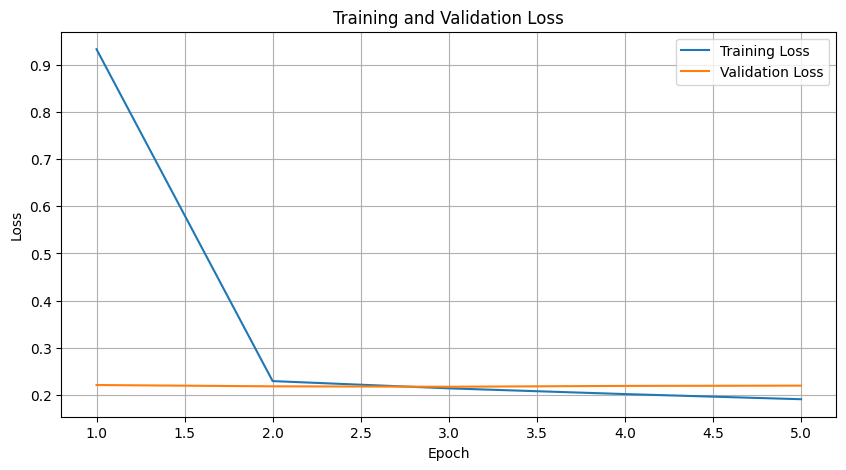

In [10]:
# Training loop
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Initialize lists for tracking training and validation losses
train_losses = []
val_losses = []

# Gradient accumulation steps to simulate a larger batch size
gradient_accumulation_steps = 4

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['epochs']}:")

    # Set model to training mode
    model.train()
    running_loss = 0

    # Iterate over batches in the training DataLoader
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass (without mixed precision)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / gradient_accumulation_steps  # Scale loss for gradient accumulation

        # Backpropagation
        loss.backward()

        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights after every `gradient_accumulation_steps`
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()  # Apply optimizer step
            optimizer.zero_grad()  # Reset gradients

        # Track running loss
        running_loss += loss.item() * gradient_accumulation_steps

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate the model on the validation dataset
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)

    # Print epoch results
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, CONFIG["epochs"] + 1), train_losses, label="Training Loss")
plt.plot(range(1, CONFIG["epochs"] + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

## Wnioski z fine-tuningu modelu BART

Proces fine-tuningu modelu BART na danych użytkownika wykazał poprawną konwergencję modelu w początkowych epokach, z wyraźnym spadkiem straty treningowej i walidacyjnej. Jednak w późniejszych epokach zaobserwowano symptomy przeuczenia (overfitting), gdy strata walidacyjna przestała spadać, mimo dalszego zmniejszania się straty treningowej.

### Kluczowe obserwacje:
1. **Konwergencja modelu**:
   - Model szybko nauczył się reprezentacji danych użytkownika w początkowych epokach, co widoczne było w gwałtownym spadku straty treningowej i walidacyjnej.

2. **Przeuczenie**:
   - W późniejszych epokach strata walidacyjna ustabilizowała się, a następnie nieznacznie wzrosła, co wskazuje na tendencję modelu do nadmiernego dopasowania się do danych treningowych.

3. **Dobry moment zatrzymania treningu**:
   - Trening został zakończony w odpowiednim momencie, gdy dalsze epoki nie przynosiłyby już istotnej poprawy na zbiorze walidacyjnym.

---

### Zalecenia:
- **Eksperymenty z hiperparametrami**:
  - Warto przeprowadzić eksperymenty z różnymi wartościami hiperparametrów, takich jak:
    - Rozmiar batcha (`batch_size`).
    - Liczba tokenów (`max_length`).
    - Współczynnik uczenia (`learning_rate`).
    - Regularizacja, np. przez mechanizm dropout lub `weight_decay`.

- **Zróżnicowanie danych**:
  - Można poprawić jakość treningu poprzez zwiększenie różnorodności danych wejściowych, co pomoże modelowi lepiej generalizować.

---

### Monitorowanie jakości generacji:
- Szczegółowa analiza generowanych streszczeń za pomocą metryk takich jak BLEU czy ROUGE będzie przeprowadzona w osobnym notatniku. To pozwoli na dokładniejszą ocenę jakości modelu w praktycznych zastosowaniach.

## Zapis modelu BART i tokenizer-a

Ten fragment kodu zapisuje wytrenowany model BART oraz odpowiadający mu tokenizer do określonego katalogu, co pozwala na ich późniejsze wykorzystanie w zadaniach takich jak generacja tekstu czy ewaluacja.

### Szczegółowy opis:

1. **Funkcja `save_model`**:
   - Zapisuje model i tokenizer do określonego katalogu.
   - Argumenty:
     - `model`: Wytrenowany model BART (`BartForConditionalGeneration`).
     - `tokenizer`: Tokenizer odpowiadający modelowi.
     - `model_name`: Nazwa katalogu, w którym zapisany zostanie model i tokenizer (domyślnie `model_v3`).

2. **Tworzenie katalogu**:
   - Ścieżka zapisu jest tworzona w katalogu `./models` z podaną nazwą modelu (`model_name`).
   - Jeśli katalog już istnieje, jest wykorzystywany bez tworzenia nowego.

3. **Zapisywanie modelu i tokenizer-a**:
   - `model.save_pretrained(save_dir)`: Zapisuje model w formacie zgodnym z biblioteką Transformers.
   - `tokenizer.save_pretrained(save_dir)`: Zapisuje tokenizer w tym samym katalogu.

4. **Komunikaty użytkowe**:
   - Informacje o lokalizacji zapisu są drukowane w konsoli, aby potwierdzić poprawne działanie.

5. **Wywołanie funkcji**:
   - Funkcja `save_model` jest wywoływana dla aktualnie wytrenowanego modelu i tokenizer-a, z domyślną nazwą `model_v3`.

### Wynik:
- Model i tokenizer są zapisywane w katalogu `./models/model_v3`.
- Pliki modelu (`pytorch_model.bin`, `config.json`) oraz tokenizer-a (`vocab.json`, `merges.txt`, `tokenizer_config.json`) są przechowywane w tym samym katalogu.

### Uwagi:
- Katalog `./models` jest domyślnym miejscem przechowywania modeli. Można go zmienić, modyfikując ścieżkę w kodzie.
- Model i tokenizer mogą być później wczytane za pomocą funkcji `BartForConditionalGeneration.from_pretrained` i `BartTokenizer.from_pretrained`.
- Zapewnienie unikalnej nazwy dla każdego modelu (`model_name`) pozwala na przechowywanie wielu wersji w jednym katalogu.

In [14]:
import os
from transformers import BartForConditionalGeneration

model_name = "model_v3"

def save_model(model, tokenizer, model_name=model_name):
    """
    Save the model and tokenizer to a specific directory.

    Args:
        model (BartForConditionalGeneration): The trained model.
        tokenizer (BartTokenizer): Tokenizer associated with the model.
        model_name (str): Name of the model directory (e.g., "model1").
    """
    # Tworzenie ścieżki katalogu
    save_dir = os.path.join("./models", model_name)
    os.makedirs(save_dir, exist_ok=True)

    # Zapisywanie modelu i tokenizer-a
    print(f"Zapisywanie modelu w: {save_dir}")
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Model i tokenizer zapisane w katalogu: {save_dir}")

# Wywołanie funkcji zapisu
save_model(model, tokenizer, model_name = model_name)

Zapisywanie modelu w: ./models/model_v3
Model i tokenizer zapisane w katalogu: ./models/model_v3


## Wczytywanie zapisanego modelu BART i tokenizer'a

Ten fragment kodu umożliwia wczytanie wcześniej zapisanego modelu BART oraz tokenizer-a z podanego katalogu.

### Szczegółowy opis:

1. **Funkcja `load_model`**:
   - Argumenty:
     - `model_name`: Nazwa katalogu, w którym zapisano model (domyślnie `model_v3`).
   - Zwraca:
     - `model`: Wczytany model BART (`BartForConditionalGeneration`).
     - `tokenizer`: Wczytany tokenizer.

2. **Proces wczytywania**:
   - Model i tokenizer są wczytywane z katalogu `./models/{model_name}` za pomocą metod `from_pretrained`.

3. **Przykład użycia**:
   - Wczytywanie modelu z katalogu `model_v3`:
     ```python
     loaded_model, loaded_tokenizer = load_model(model_name="model_v3")
     ```

### Wynik:
- Model i tokenizer są gotowe do użycia w aplikacjach NLP, takich jak generacja tekstu czy ewaluacja.

### Uwagi:
- Katalog `./models/{model_name}` musi zawierać wcześniej zapisany model i tokenizer.
- Funkcja jest zgodna z formatem zapisu w bibliotece Transformers.

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

model_name = "model_v3"

def load_model(model_name=model_name):
    """
    Load a saved model and tokenizer.

    Args:
        model_name (str): Name of the saved model directory (e.g., "model1").

    Returns:
        tuple: Loaded model and tokenizer.
    """
    # Ścieżka do zapisanego modelu
    load_dir = os.path.join("./models", model_name)

    # Wczytanie modelu i tokenizer-a
    print(f"Wczytywanie modelu z katalogu: {load_dir}")
    model = BartForConditionalGeneration.from_pretrained(load_dir)
    tokenizer = BartTokenizer.from_pretrained(load_dir)
    return model, tokenizer

# Przykład wczytania modelu
loaded_model, loaded_tokenizer = load_model(model_name=model_name)

Wczytywanie modelu z katalogu: ./models/model_v3


## Generowanie podsumowań z modelu BART i porównanie wyników

Ten fragment kodu wczytuje wcześniej zapisany model BART, generuje podsumowanie dla losowo wybranego artykułu z zestawu testowego, i porównuje je z podsumowaniem zawartym w danych.

### Szczegółowy opis:

1. **Wczytanie modelu i tokenizer-a**:
   - Funkcja `load_model` wczytuje model i tokenizer z katalogu `./models/{model_name}`.
   - Model jest przenoszony na urządzenie (`device`) przed generowaniem podsumowań.

2. **Wczytanie danych testowych**:
   - Funkcja `load_test_data` ładuje dane testowe z pliku JSON podanego w zmiennej `test_file_path`.

3. **Generowanie podsumowania**:
   - Funkcja `generate_summary` wykorzystuje model BART do wygenerowania podsumowania dla zadanego tekstu.
   - Parametry podsumowania:
     - `max_length`: Maksymalna długość wygenerowanego podsumowania (domyślnie 150 tokenów).
     - `min_length`: Minimalna długość wygenerowanego podsumowania (domyślnie 40 tokenów).
     - `num_beams`: Liczba ścieżek eksplorowanych podczas generacji (domyślnie 4).

4. **Porównanie wyników**:
   - Losowy artykuł z danych testowych (`random_article`) jest wybrany do analizy.
   - Wyświetlane są:
     - Oryginalny tekst artykułu.
     - Podsumowanie zapisane w zestawie danych (`Dataset Summary`).
     - Podsumowanie wygenerowane przez model (`Model-Generated Summary`).

5. **Wyświetlanie wyników**:
   - Tekst i podsumowania są formatowane za pomocą biblioteki `textwrap` dla lepszej czytelności (maksymalna szerokość linii: 80 znaków).

### Wynik:
- Kod generuje podsumowanie dla losowego artykułu i wyświetla porównanie pomiędzy:
  - Oryginalnym tekstem.
  - Podsumowaniem zapisanym w zestawie danych.
  - Podsumowaniem wygenerowanym przez model.

In [ ]:
import os
import json
import random
from transformers import BartTokenizer, BartForConditionalGeneration
import textwrap


def load_model(model_name, base_dir="./models"):
    """
    Load a saved model and tokenizer.

    Args:
        model_name (str): Name of the saved model directory.
        base_dir (str): Base directory where models are saved.

    Returns:
        tuple: Loaded model and tokenizer.
    """
    model_path = os.path.join(base_dir, model_name)
    model = BartForConditionalGeneration.from_pretrained(model_path)
    tokenizer = BartTokenizer.from_pretrained(model_path)
    return model, tokenizer


def load_test_data(file_path):
    """
    Load test data from a JSON file.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        list: List of articles from the dataset.
    """
    with open(file_path, "r") as file:
        return json.load(file)


def generate_summary(model, tokenizer, text, max_length=150, min_length=40):
    """
    Generate a summary for the given text.

    Args:
        model: Pre-trained BART model.
        tokenizer: BART tokenizer.
        text (str): Input text to summarize.
        max_length (int): Maximum length of the summary.
        min_length (int): Minimum length of the summary.

    Returns:
        str: Generated summary.
    """
    inputs = tokenizer(
        text,
        max_length=512,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)
    
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# Load model and tokenizer
model_name = "model_v3"  # Specify the model name
model, tokenizer = load_model(model_name)
model.to(device)

# Load test dataset
test_file_path = "./datasets/splits_filtered_with_summary/test.json"
test_data = load_test_data(test_file_path)

# Select a random article
random_article = random.choice(test_data)

# Extract original text and summaries
original_text = random_article["text"]
dataset_summary = random_article["summary"]
generated_summary = generate_summary(model, tokenizer, original_text)

# Display comparison side-by-side
print("=== Comparison ===\n")

print("Original Text:")
print(textwrap.fill(original_text, width=80))

print("\nDataset Summary:")
print(textwrap.fill(dataset_summary, width=80))

print("\nModel-Generated Summary:")
print(textwrap.fill(generated_summary, width=80))

=== Porównanie ===

Oryginalny tekst:
This is MORNING EDITION from NPR News. Good morning. I'm Renee Montagne. NPR's
Scott Horsley was along for the ride and has this report. President Obama hosted
four town hall meetings and an economic conference during this bus tour. But the
heart of the trip came in-between those big scheduled events, as Mr. Obama
traveled the countryside, visiting with high school sports teams, stopping at a
county fair, and saluting uniformed firefighters standing at attention outside
their small town firehouse. You're passing rows of kids with flags and
grandparents in their lawn chairs and mechanics out in front of their shops and,
you know, farmers waving from their fields, and it inspires you. 'Cause it
reminds you about what makes this country so great. Some of the people lining
the street to shake hands with Mr. Obama remember his first presidential
campaign four years ago, back when his hair was not so grey. Yeah, somebody had
like an old flyer I'd send hi